In [2]:
# IMPORTAMOS TODO LO NECESARIO

#!pip install pyathena
#!pip install boto3
#!pip install XlsxWriter
#!pip install pandas openpyxl

In [2]:
# CONECTAMOS A ATHENA 

conn = connect(
    aws_access_key_id="***********",
    aws_secret_access_key="*************************",
    s3_staging_dir='s3://-athena-scripts/external/',
    region_name="us-west-1" 
    
)

In [12]:
# QUERY RELACIONADA A ESTIMACIÓN

query = ''' 

with x AS (
SELECT
    flag_controlled_final_medition_vs_client_sla_overdue,
    if(diff_sla_stadistics <= 0,1,0)                                                                                                      AS flag_estimate_overdue,
    CASE WHEN f.wh_total_working_days > s.p80_wh_total_working_days then 1 else 0 end                                                     AS flag_wh_overdue,
    CASE WHEN f.td_total_working_days > s.p80_td_total_working_days then 1 else 0 end                                                     AS flag_td_overdue,
    CASE WHEN f.ad_total_working_days > s.p80_ad_total_working_days then 1 else 0 end                                                     AS flag_ad_overdue,
    CASE WHEN f.wi_total_working_days + f.rc_total_working_days + f.lm_total_working_days > s.p80_um_total_working_days then 1 else 0 end AS flag_um_overdue,
    COUNT (package_id)                                                                                                                    AS packages
FROM tabla_1 f 
left join tabla_2 s using (key_statistics)
WHERE f.flag_delivered = 1 
GROUP BY 1,2,3,4,5,6
)
SELECT
    flag_wh_overdue,
    flag_td_overdue,
    flag_ad_overdue,
    flag_um_overdue,
    packages
FROM x
WHERE 1=1
    AND flag_controlled_final_medition_vs_client_sla_overdue = 0
    AND flag_estimate_overdue = 1;

'''
cursor = conn.cursor()
cursor.execute(query)


results = cursor.fetchall()

In [ ]:
#Guardamos en Dataframe

df = pd.DataFrame(results, 
                  columns=['flag_wh_overdue',
                           'flag_td_overdue',
                           'flag_ad_overdue',
                           'flag_um_overdue',
                           'packages'
]                  )

In [130]:
# Ordenar el DataFrame por la columna 'paquetes' en orden descendente
df_ordenado = df.sort_values(by='paquetes', ascending=False)

#print(df)
#print("\n DATA TYPE********** \n" )
#print(df.dtypes)

### Grafico buble para ver como se relaciónan


In [144]:
df_buble = pd.DataFrame(df_ordenado)

# Crear una nueva columna con la suma de flags
df_buble['total_flags'] = df_ordenado[['flag_wh_overdue', 'flag_td_overdue', 'flag_ad_overdue', 'flag_um_overdue']].sum(axis=1)
print(df_buble)


    flag_wh_overdue  flag_td_overdue  flag_ad_overdue  flag_um_overdue  \
7                 0                0                0                0   
8                 0                0                0                1   
1                 0                0                1                0   
3                 0                0                1                1   
4                 1                0                0                0   
13                0                1                0                0   
2                 1                0                0                1   
10                1                1                0                0   
14                1                0                1                0   
11                0                1                0                1   
9                 0                1                1                0   
15                1                1                0                1   
12                1                0  

In [140]:
# Agrupar por la cantidad de flags activados
grouped = df_buble.groupby('total_flags')['packages'].sum().reset_index()

# Mostrar el DataFrame ordenado
print(grouped)


   total_flags  paquetes
0            0   2496577
1            1   1822446
2            2    615239
3            3     83033
4            4      5169


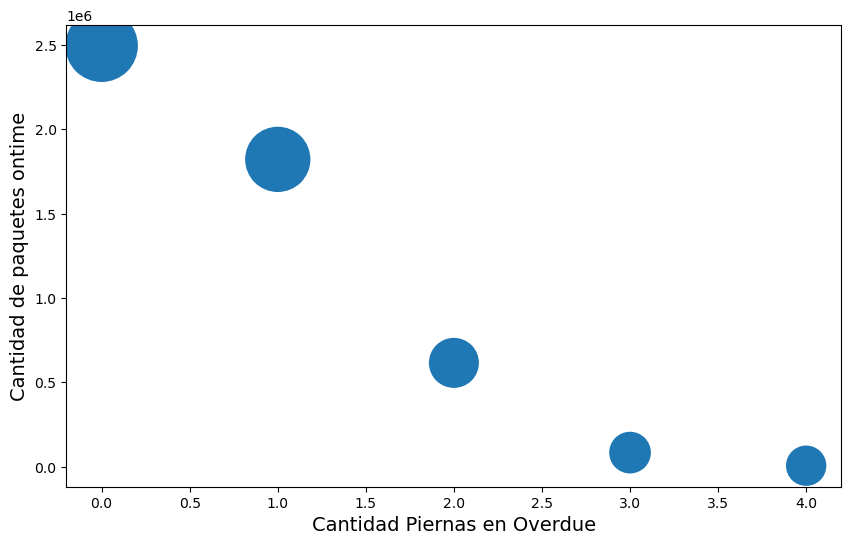

In [88]:
# Crear el gráfico de burbujas
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=grouped, 
    x='total_flags', 
    y='packages', 
    size='paquetes', 
    sizes=(1000, 3000),  # Escala del tamaño de las burbujas
    legend=False 
)


# Configurar etiquetas y títulos
#plt.title('Impacto de la cantidad de flags en los paquetes ontime', fontsize=16)
plt.xlabel('Cantidad Piernas en Overdue', fontsize=14)
plt.ylabel('Cantidad de paquetes ontime', fontsize=14)

# Mostrar el gráfico
plt.show()

In [146]:

df_buble_color = pd.DataFrame(df_buble)

# Agrupar por la cantidad de flags activados
#buble_color_grupet = df_buble_color.groupby(['total_flags', 'flag_wh_overdue', 'flag_td_overdue', 'flag_ad_overdue', 'flag_um_overdue'])['paquetes'].sum().reset_index()

# Mostrar el DataFrame ordenado
#print(buble_color_grupet)



In [150]:
 #Crear una lista para almacenar las nuevas filas
rows = []

# Iterar por cada fila del dataframe original
for _, row in df_buble_color.iterrows():
    if row['flag_wh_overdue'] == 1:
        rows.append({**row, 'color': 'yellow'})
    if row['flag_td_overdue'] == 1:
        rows.append({**row, 'color': 'purple'})
    if row['flag_ad_overdue'] == 1:
        rows.append({**row, 'color': 'blue'})
    if row['flag_um_overdue'] == 1:
        rows.append({**row, 'color': 'green'})
    if row['total_flags'] == 0:
        rows.append({**row, 'color': 'gray'})

# Crear un nuevo dataframe con las filas expandidas
expanded_df = pd.DataFrame(rows)



In [164]:
# Diccionario de mapeo entre colores y flags
color_to_flag = {
    'yellow': 'WH',
    'purple': 'TD',
    'blue': 'AD',
    'green': 'UM',
    'gray': 'NONE'
}

# Agregar la columna 'flag_correspondiente'
expanded_df['flag_correspondiente'] = expanded_df['color'].map(color_to_flag)

print(expanded_df)


    flag_wh_overdue  flag_td_overdue  flag_ad_overdue  flag_um_overdue  \
0                 0                0                0                0   
1                 0                0                0                1   
2                 0                0                1                0   
3                 0                0                1                1   
4                 0                0                1                1   
5                 1                0                0                0   
6                 0                1                0                0   
7                 1                0                0                1   
8                 1                0                0                1   
9                 1                1                0                0   
10                1                1                0                0   
11                1                0                1                0   
12                1                0  

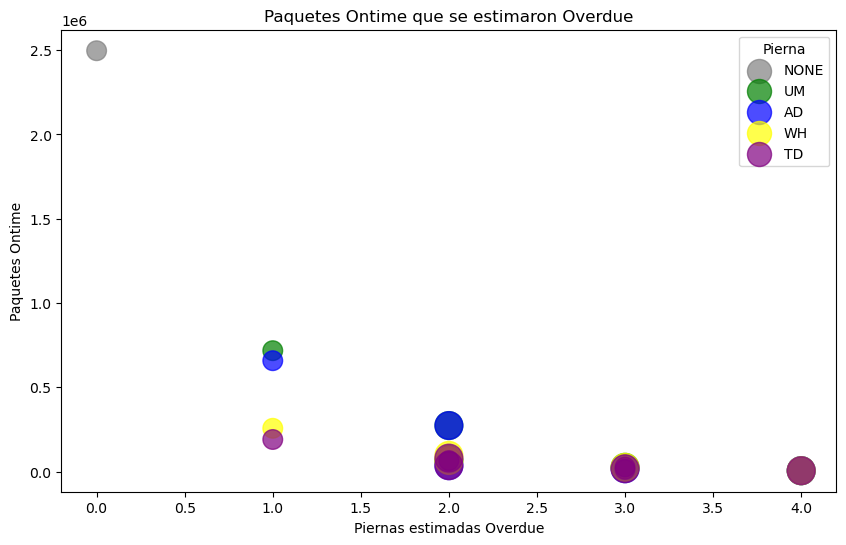

In [184]:

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar usando el color de cada fila
for color in expanded_df['color'].unique():
    subset = expanded_df[expanded_df['color'] == color]
    plt.scatter(
        subset['total_flags'],  # eje x
        subset['packages'],  # eje Y
        color=color,
        label=color_to_flag[color],
        sizes=(200, 400), 
        alpha=0.7
    )

# Configurar el gráfico
plt.xlabel('Legs Estimated Overdue')
plt.ylabel('Packages Ontime')
plt.title('Packages Ontime Estimated Overdue')
plt.legend(title='Leg')
plt.show()


### Comenzamos un analisis de correlación
ESTO NOS VA A AYUDAR A VER SI EXISTE UNA RELACIÓN ENTRE QUE UN PAQUETE ESTE OVERDUE EN UNA PIERNA Y ESTE OVERDUE EN OTRA

In [174]:
# Seleccionar las columnas de interés y calcular la matriz de correlación
columns_to_analyze = ['flag_wh_overdue', 'flag_td_overdue', 
                      'flag_ad_overdue', 'flag_um_overdue','paquetes']

# Calcular la matriz de correlación
correlation_matrix_tmp = df_ordenado[columns_to_analyze].corr()

# Redondeo
correlation_matrix = correlation_matrix_tmp.round(2)

# Mostrar la matriz de correlación
print(correlation_matrix)

                 flag_wh_overdue  flag_td_overdue  flag_ad_overdue  \
flag_wh_overdue              1.0             0.00            -0.00   
flag_td_overdue              0.0             1.00            -0.00   
flag_ad_overdue             -0.0            -0.00             1.00   
flag_um_overdue             -0.0             0.00             0.00   
paquetes                    -0.4            -0.43            -0.29   

                 flag_um_overdue  paquetes  
flag_wh_overdue            -0.00     -0.40  
flag_td_overdue             0.00     -0.43  
flag_ad_overdue             0.00     -0.29  
flag_um_overdue             1.00     -0.27  
paquetes                   -0.27      1.00  


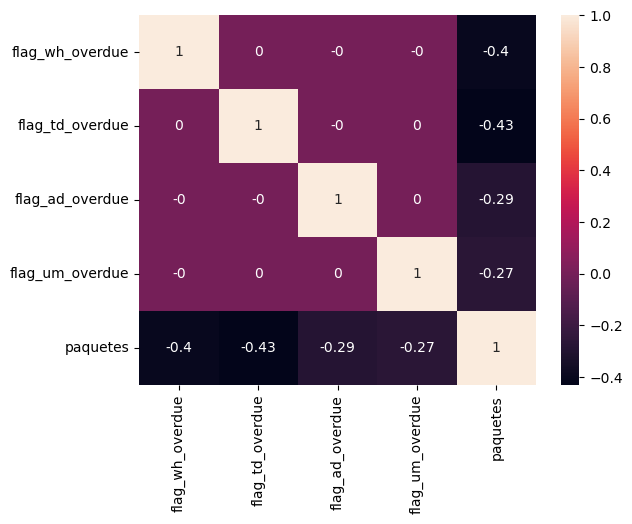

In [178]:
sns.heatmap(correlation_matrix,annot =True)
plt.show()


# MIENTRAS MAS CERCA DE 1 ESTE, MAS INCIDENCIA TENDRA AL MOMENTO DE DEFINIR SI LLEGA OVERDUE O NO 

### Fin correlación


Al ser todos valores cercanos a 0, entendemos que no influye el performance de una pierna en otra, salgo en la relación wh hub. 
Esto se puede deber a que los paquetes que llegan overdue desde el wh origen, se pushean mas rapido en hb (confirmar)